## 1. Serial implementation

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn import preprocessing

In [2]:
# Load the data
df = pd.read_csv('data/Auto.csv', na_values=['?'])
df.dropna(inplace=True)

# Create a binary variable indicating whether `mpg` is higher than the median. 
df['mpg_high'] = np.where(df['mpg'] >= np.median(df['mpg']), 1, 0)

# Create dummies for origin. 
df = pd.get_dummies(df, prefix='origin', columns=['origin']).drop(columns=['origin_3'])

df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,name,mpg_high,origin_1,origin_2
0,18.0,8,307.0,130.0,3504,12.0,70,chevrolet chevelle malibu,0,1,0
1,15.0,8,350.0,165.0,3693,11.5,70,buick skylark 320,0,1,0
2,18.0,8,318.0,150.0,3436,11.0,70,plymouth satellite,0,1,0
3,16.0,8,304.0,150.0,3433,12.0,70,amc rebel sst,0,1,0
4,17.0,8,302.0,140.0,3449,10.5,70,ford torino,0,1,0


In [3]:
# Set X and Y
X = df[['cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin_1', 'origin_2']].values
X = preprocessing.scale(X)
y = df[['mpg_high']].values.reshape(len(X), )

In [4]:
%%time
# Set the cross-validation method
rs = ShuffleSplit(n_splits=100, train_size=.65, random_state=0)

# Set the Logistic regressor
logit_reg = LogisticRegression(n_jobs=1)

# Cross validate and get the score
scores = cross_val_score(logit_reg, X, y, cv=rs, scoring='accuracy')

# Calculate the mean error rate
print('Mean error rate: ', 1 - scores.mean())

Mean error rate:  0.09594202898550708
CPU times: user 613 ms, sys: 6.65 ms, total: 620 ms
Wall time: 623 ms


## 2. Dask Parallel Implementation

In [5]:
from sklearn.metrics import accuracy_score
from dask.distributed import Client
from dask import delayed

In [6]:
@delayed
def est_accuracy(bootstrap_ind, seed, X, y): 
    
    # Set the resampling method
    rs = ShuffleSplit(n_splits=100, train_size=.65, random_state=seed)
    
    # Split the data set
    train_ind, test_ind = [(train_ind, test_ind) for train_ind, test_ind in rs.split(X, y)][bootstrap_ind]
    
    # Train the model on training data
    logit_reg = LogisticRegression(n_jobs=1)
    logit_reg.fit(X[train_ind], y[train_ind])
    
    # Predict on the test data
    y_pred = logit_reg.predict(X[test_ind])
    
    # return the error rate
    return 1 - accuracy_score(y[test_ind], y_pred)

In [7]:
# Load the data
df = pd.read_csv('data/Auto.csv', na_values=['?'])
df.dropna(inplace=True)

# Create a binary variable indicating whether `mpg` is higher than the median. 
df['mpg_high'] = np.where(df['mpg'] >= np.median(df['mpg']), 1, 0)

# Create dummies for origin. 
df = pd.get_dummies(df, prefix='origin', columns=['origin']).drop(columns=['origin_3'])

# Set X and Y
X = df[['cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin_1', 'origin_2']].values
X = preprocessing.scale(X)
y = df[['mpg_high']].values.reshape(len(y), )

In [11]:
error_rate_list = []
for i in range(100): 
    error_rate_list.append(est_accuracy(i, 0, X, y))
mean_error_rate = delayed(lambda x: sum(x)/100)(error_rate_list)

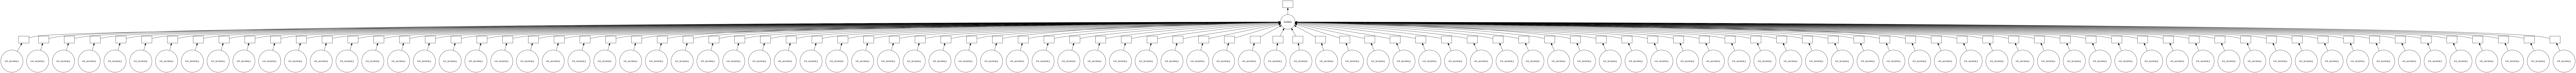

In [12]:
mean_error_rate.visualize(scheduler='distribute')

In [13]:
%%time
print('Mean error rate: ', mean_error_rate.compute())

Mean error rate:  0.09594202898550726
CPU times: user 837 ms, sys: 118 ms, total: 955 ms
Wall time: 858 ms


The parallel implementation takes even longer time. This may due to the heavy communication across CPU cores when reducing the error rates to their mean. However, the parallel implementation can be significantly efficient if the data volume is out of memory. 